# Memory Information and GPU Information



In [ ]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 12.69GB
Available: 11.90GB
Used: 537.08MB
Percentage: 6.2%


In [ ]:
! nvidia-smi

Thu May 27 09:33:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import utils

# Downloading Dataset and Creatng Data Loaders

In [ ]:
torch.manual_seed(1)
batch_size = 64

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_data = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))]))
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,
                                           shuffle=True, **kwargs)

test_data = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))]))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=True, **kwargs)

# Training and Test Functions 

In [ ]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

    train_loss /= len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)

    return train_loss, accuracy

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    return test_loss, accuracy

# Vanila Basic Model

In [ ]:
class Net_Vanilla(nn.Module):
    def __init__(self):
        super(Net_Vanilla, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) # 28x28x3 -> 28x28x32
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # 28x28x32 -> 28x28x64
        self.pool1 = nn.MaxPool2d(2, 2) # 28x28x64 -> 14x14x64
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1) # 14x14x64 -> 14x14x128
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1) # 14x14x128 -> 14x14x256
        self.pool2 = nn.MaxPool2d(2, 2) # 14x14x256 -> 7x7x256
        self.conv5 = nn.Conv2d(256, 512, 3) # 7x7x256 -> 5x5x512
        self.conv6 = nn.Conv2d(512, 1024, 3) # 5x5x512 -> 3x3x1024
        self.conv7 = nn.Conv2d(1024, 10, 3) # 3x3x1024 -> 1x1x1024

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        x = self.conv7(x)
        
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=1)

## Model Summary

In [ ]:
model = Net_Vanilla().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.51
Params size (MB): 24.34
Estimated Total Size (MB): 25.85
-------------------------------------

### Statistics

Number of Parameters: **6,379,786**

In [ ]:
model = Net_Vanilla().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 5):
    train_loss, train_acc = train(model, device, train_loader, optimizer)
    test_loss, test_acc = test(model, device, test_loader)
    print('\nTRAIN set: Average loss: {:.4f}, Train Accuracy: {:.2f}%'.format(train_loss,train_acc))
    print('TEST set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss,test_acc))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.2316, Train Accuracy: 92.72%)
TEST set: Average loss: 0.0532, Test Accuracy: 98.29%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0418, Train Accuracy: 98.72%)
TEST set: Average loss: 0.0366, Test Accuracy: 98.91%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0270, Train Accuracy: 99.19%)
TEST set: Average loss: 0.0323, Test Accuracy: 98.97%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


loss=0.0005905351135879755 batch_id=937: 100%|██████████| 938/938 [00:21<00:00, 42.92it/s]



TRAIN set: Average loss: 0.0191, Train Accuracy: 99.42%)
TEST set: Average loss: 0.0268, Test Accuracy: 98.99%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


## Results:

Train Accuracy: **99.42**  
Test Accuracy: **98.99**

# Model with Batch Norm and GAP

In [ ]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1) # 28x28x3 -> 28x28x8
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 8, 3, padding=1) # 28x28x8 -> 28x28x8
        self.bn2 = nn.BatchNorm2d(8)
        self.pool1 = nn.MaxPool2d(2, 2) # 28x28x8 -> 14x14x8
        
        self.conv3 = nn.Conv2d(8, 8, 3, padding=1) # 14x14x12 -> 14x14x16
        self.bn3 = nn.BatchNorm2d(8)
        self.conv4 = nn.Conv2d(8, 8, 3, padding=1) # 14x14x16 -> 14x14x24
        self.bn4 = nn.BatchNorm2d(8)
        self.pool2 = nn.MaxPool2d(2, 2) # 14x14x24 -> 7x7x24
        
        self.conv5 = nn.Conv2d(8, 16, 3) # 7x7x24 -> 5x5x32
        self.bn5 = nn.BatchNorm2d(16)
        self.conv6 = nn.Conv2d(16, 16, 3) # 5x5x32 -> 3x3x32
        
        self.gap = nn.AvgPool2d(3) # 3x3x32 -> 1x1x32
        self.fc1 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.pool1(x)

        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.pool2(x)

        x = self.bn5(F.relu(self.conv5(x)))
        x = self.gap(self.conv6(x))
        x = x.view(-1,16)
        x = self.fc2(F.relu(self.fc1(x)))        
        
        
        return F.log_softmax(x, dim=1)

## Model Summary

In [ ]:
model = Net1().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
            Conv2d-3            [-1, 8, 28, 28]             584
       BatchNorm2d-4            [-1, 8, 28, 28]              16
         MaxPool2d-5            [-1, 8, 14, 14]               0
            Conv2d-6            [-1, 8, 14, 14]             584
       BatchNorm2d-7            [-1, 8, 14, 14]              16
            Conv2d-8            [-1, 8, 14, 14]             584
       BatchNorm2d-9            [-1, 8, 14, 14]              16
        MaxPool2d-10              [-1, 8, 7, 7]               0
           Conv2d-11             [-1, 16, 5, 5]           1,168
      BatchNorm2d-12             [-1, 16, 5, 5]              32
           Conv2d-13             [-1, 16, 3, 3]           2,320
        AvgPool2d-14             [-1, 1

### Statistics

Number of Parameters: **6,290**

In [ ]:
model = Net1().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train(model, device, train_loader, optimizer)
    test_loss, test_acc = test(model, device, test_loader)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    
    print('\nTRAIN set: Average loss: {:.4f}, Train Accuracy: {:.2f}%'.format(train_loss,train_acc))
    print('TEST set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss,test_acc))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.3206, Train Accuracy: 89.92%
TEST set: Average loss: 0.0767, Test Accuracy: 97.51%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0627, Train Accuracy: 98.07%
TEST set: Average loss: 0.0613, Test Accuracy: 98.01%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0474, Train Accuracy: 98.50%
TEST set: Average loss: 0.0443, Test Accuracy: 98.57%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0391, Train Accuracy: 98.77%
TEST set: Average loss: 0.0393, Test Accuracy: 98.78%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0346, Train Accuracy: 98.89%
TEST set: Average loss: 0.0304, Test Accuracy: 98.99%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0321, Train Accuracy: 98.97%
TEST set: Average loss: 0.0303, Test Accuracy: 98.91%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 7


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0275, Train Accuracy: 99.12%
TEST set: Average loss: 0.0314, Test Accuracy: 98.92%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 8


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0260, Train Accuracy: 99.16%
TEST set: Average loss: 0.0293, Test Accuracy: 99.04%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 9


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0247, Train Accuracy: 99.22%
TEST set: Average loss: 0.0333, Test Accuracy: 98.98%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 10


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0223, Train Accuracy: 99.28%
TEST set: Average loss: 0.0291, Test Accuracy: 99.05%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 11


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0205, Train Accuracy: 99.34%
TEST set: Average loss: 0.0305, Test Accuracy: 98.99%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 12


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0192, Train Accuracy: 99.35%
TEST set: Average loss: 0.0282, Test Accuracy: 99.08%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 13


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0186, Train Accuracy: 99.39%
TEST set: Average loss: 0.0280, Test Accuracy: 99.08%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 14


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0170, Train Accuracy: 99.42%
TEST set: Average loss: 0.0324, Test Accuracy: 99.04%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 15


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0163, Train Accuracy: 99.47%
TEST set: Average loss: 0.0349, Test Accuracy: 98.96%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 16


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0158, Train Accuracy: 99.49%
TEST set: Average loss: 0.0275, Test Accuracy: 99.10%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 17


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0158, Train Accuracy: 99.48%
TEST set: Average loss: 0.0273, Test Accuracy: 99.14%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 18


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0146, Train Accuracy: 99.50%
TEST set: Average loss: 0.0302, Test Accuracy: 99.06%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 19


loss=0.0004961212398484349 batch_id=937: 100%|██████████| 938/938 [00:15<00:00, 59.30it/s]



TRAIN set: Average loss: 0.0139, Train Accuracy: 99.53%
TEST set: Average loss: 0.0345, Test Accuracy: 99.00%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Train Accuracy:  99.53
Test Accuracy:  99.14


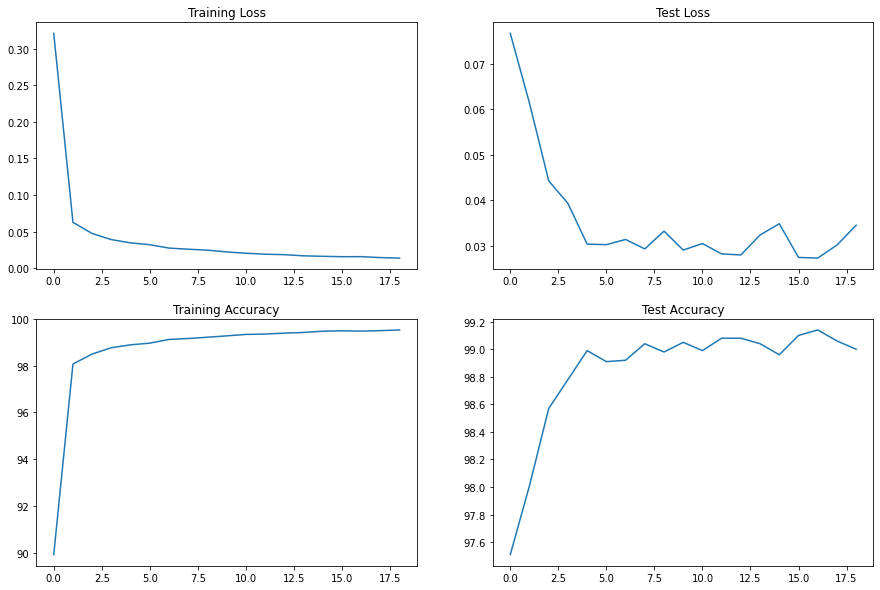

In [ ]:
print('Train Accuracy: ', max(train_acc_list))
print('Test Accuracy: ', max(test_acc_list))

utils.plot_loss_acc(train_loss_list, train_acc_list, test_loss_list, test_acc_list)

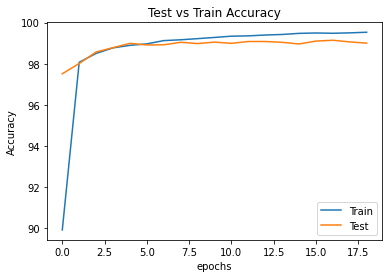

In [ ]:
utils.plot_combined(train_acc_list, test_acc_list)

## Results:

Train Accuracy: **99.53**  
Test Accuracy: **99.14**

The Model is Overfitting, so let's try some Regularization by using a technique called **DropOut**.

### DropOut

During training, Drouput randomly zeroes some of the elements of the input tensor with probability p using samples from a Bernoulli distribution. Each channel will be zeroed out independently on every forward call.

This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons as described in the paper Improving neural networks by preventing co-adaptation of feature detectors .

Furthermore, the outputs are scaled by a factor of $\frac{1}{1-p}$ during training. This means that during evaluation the module simply computes an identity function.

# Model with BatchNorm, GAP and DropOut

In [ ]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1) # 28x28x3 -> 28x28x8
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 8, 3, padding=1) # 28x28x8 -> 28x28x8
        self.bn2 = nn.BatchNorm2d(8)
        self.pool1 = nn.MaxPool2d(2, 2) # 28x28x8 -> 14x14x8
        
        self.conv3 = nn.Conv2d(8, 8, 3, padding=1) # 14x14x12 -> 14x14x16
        self.bn3 = nn.BatchNorm2d(8)
        self.conv4 = nn.Conv2d(8, 8, 3, padding=1) # 14x14x16 -> 14x14x24
        self.bn4 = nn.BatchNorm2d(8)
        self.pool2 = nn.MaxPool2d(2, 2) # 14x14x24 -> 7x7x24
        
        self.conv5 = nn.Conv2d(8, 16, 3) # 7x7x24 -> 5x5x32
        self.bn5 = nn.BatchNorm2d(16)
        self.conv6 = nn.Conv2d(16, 16, 3) # 5x5x32 -> 3x3x32
        
        self.gap = nn.AvgPool2d(3) # 3x3x32 -> 1x1x32
        self.fc1 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 10)

        self.drop = nn.Dropout(p=0.05) #5% Neurons being Dropped

    def forward(self, x):
        x = self.drop(self.bn1(F.relu(self.conv1(x))))
        x = self.drop(self.bn2(F.relu(self.conv2(x))))
        x = self.pool1(x)

        x = self.drop(self.bn3(F.relu(self.conv3(x))))
        x = self.drop(self.bn4(F.relu(self.conv4(x))))
        x = self.pool2(x)

        x = self.drop(self.bn5(F.relu(self.conv5(x))))
        x = self.gap(self.conv6(x))
        x = x.view(-1,16)
        x = self.fc2(F.relu(self.fc1(x)))
        
        
        return F.log_softmax(x, dim=1)

In [ ]:
model = Net2().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
           Dropout-3            [-1, 8, 28, 28]               0
            Conv2d-4            [-1, 8, 28, 28]             584
       BatchNorm2d-5            [-1, 8, 28, 28]              16
           Dropout-6            [-1, 8, 28, 28]               0
         MaxPool2d-7            [-1, 8, 14, 14]               0
            Conv2d-8            [-1, 8, 14, 14]             584
       BatchNorm2d-9            [-1, 8, 14, 14]              16
          Dropout-10            [-1, 8, 14, 14]               0
           Conv2d-11            [-1, 8, 14, 14]             584
      BatchNorm2d-12            [-1, 8, 14, 14]              16
          Dropout-13            [-1, 8, 14, 14]               0
        MaxPool2d-14              [-1, 

### Statistics

Number of Parameters: **6,290**

In [ ]:
model = Net2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train(model, device, train_loader, optimizer)
    test_loss, test_acc = test(model, device, test_loader)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    
    print('\nTRAIN set: Average loss: {:.4f}, Train Accuracy: {:.2f}%'.format(train_loss,train_acc))
    print('TEST set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss,test_acc))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.3589, Train Accuracy: 87.97%
TEST set: Average loss: 0.0928, Test Accuracy: 97.12%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0739, Train Accuracy: 97.70%
TEST set: Average loss: 0.0548, Test Accuracy: 98.19%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0564, Train Accuracy: 98.21%
TEST set: Average loss: 0.0392, Test Accuracy: 98.68%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0488, Train Accuracy: 98.44%
TEST set: Average loss: 0.0395, Test Accuracy: 98.73%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0454, Train Accuracy: 98.58%
TEST set: Average loss: 0.0393, Test Accuracy: 98.74%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0400, Train Accuracy: 98.73%
TEST set: Average loss: 0.0364, Test Accuracy: 98.80%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 7


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0380, Train Accuracy: 98.75%
TEST set: Average loss: 0.0381, Test Accuracy: 98.90%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 8


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0341, Train Accuracy: 98.92%
TEST set: Average loss: 0.0297, Test Accuracy: 99.03%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 9


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0344, Train Accuracy: 98.87%
TEST set: Average loss: 0.0328, Test Accuracy: 99.01%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 10


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0329, Train Accuracy: 98.89%
TEST set: Average loss: 0.0342, Test Accuracy: 98.87%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 11


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0315, Train Accuracy: 98.99%
TEST set: Average loss: 0.0273, Test Accuracy: 99.15%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 12


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0301, Train Accuracy: 99.02%
TEST set: Average loss: 0.0304, Test Accuracy: 99.08%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 13


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0300, Train Accuracy: 99.06%
TEST set: Average loss: 0.0292, Test Accuracy: 99.00%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 14


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0264, Train Accuracy: 99.12%
TEST set: Average loss: 0.0233, Test Accuracy: 99.24%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 15


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0276, Train Accuracy: 99.12%
TEST set: Average loss: 0.0228, Test Accuracy: 99.28%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 16


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0261, Train Accuracy: 99.19%
TEST set: Average loss: 0.0261, Test Accuracy: 99.11%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 17


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0247, Train Accuracy: 99.17%
TEST set: Average loss: 0.0295, Test Accuracy: 99.04%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 18


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0242, Train Accuracy: 99.19%
TEST set: Average loss: 0.0302, Test Accuracy: 99.01%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 19


loss=0.0013420998584479094 batch_id=937: 100%|██████████| 938/938 [00:15<00:00, 58.93it/s]



TRAIN set: Average loss: 0.0251, Train Accuracy: 99.19%
TEST set: Average loss: 0.0248, Test Accuracy: 99.20%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Train Accuracy:  99.195
Test Accuracy:  99.28


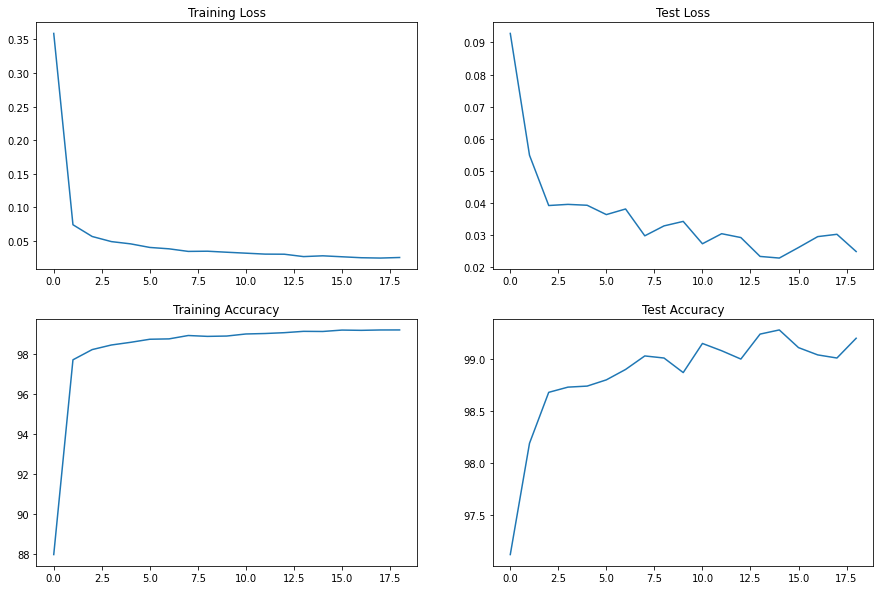

In [ ]:
print('Train Accuracy: ', max(train_acc_list))
print('Test Accuracy: ', max(test_acc_list))

utils.plot_loss_acc(train_loss_list, train_acc_list, test_loss_list, test_acc_list)

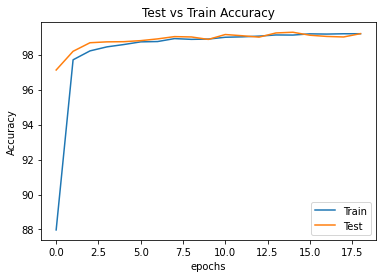

In [ ]:
utils.plot_combined(train_acc_list, test_acc_list)

### Results

Train Accuracy: **99.195**  
Test Accuracy: **99.28**

# Back to Data Augmentation

Adding Some Radom Rotation of -12 to +12 degrees to Images

### Data

In [ ]:
torch.manual_seed(1)
batch_size = 64

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_data = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation(12),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))]))
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,
                                           shuffle=True, **kwargs)

test_data = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))]))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=True, **kwargs)

### Training Model 1 - BN + GAP + FC



In [ ]:
model = Net1().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train(model, device, train_loader, optimizer)
    test_loss, test_acc = test(model, device, test_loader)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    
    print('\nTRAIN set: Average loss: {:.4f}, Train Accuracy: {:.2f}%'.format(train_loss,train_acc))
    print('TEST set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss,test_acc))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.3455, Train Accuracy: 88.65%
TEST set: Average loss: 0.0527, Test Accuracy: 98.41%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0780, Train Accuracy: 97.58%
TEST set: Average loss: 0.0558, Test Accuracy: 98.22%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0606, Train Accuracy: 98.09%
TEST set: Average loss: 0.0448, Test Accuracy: 98.60%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0518, Train Accuracy: 98.40%
TEST set: Average loss: 0.0342, Test Accuracy: 98.99%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0481, Train Accuracy: 98.48%
TEST set: Average loss: 0.0265, Test Accuracy: 99.16%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0444, Train Accuracy: 98.63%
TEST set: Average loss: 0.0262, Test Accuracy: 99.15%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 7


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0401, Train Accuracy: 98.77%
TEST set: Average loss: 0.0239, Test Accuracy: 99.25%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 8


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0393, Train Accuracy: 98.76%
TEST set: Average loss: 0.0216, Test Accuracy: 99.35%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 9


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0360, Train Accuracy: 98.82%
TEST set: Average loss: 0.0212, Test Accuracy: 99.34%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 10


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0351, Train Accuracy: 98.89%
TEST set: Average loss: 0.0208, Test Accuracy: 99.29%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 11


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0332, Train Accuracy: 98.94%
TEST set: Average loss: 0.0200, Test Accuracy: 99.31%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 12


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0324, Train Accuracy: 98.95%
TEST set: Average loss: 0.0242, Test Accuracy: 99.31%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 13


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0320, Train Accuracy: 98.93%
TEST set: Average loss: 0.0196, Test Accuracy: 99.34%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 14


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0308, Train Accuracy: 99.02%
TEST set: Average loss: 0.0197, Test Accuracy: 99.40%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 15


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0292, Train Accuracy: 99.04%
TEST set: Average loss: 0.0204, Test Accuracy: 99.35%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 16


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0291, Train Accuracy: 99.04%
TEST set: Average loss: 0.0210, Test Accuracy: 99.32%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 17


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0278, Train Accuracy: 99.11%
TEST set: Average loss: 0.0198, Test Accuracy: 99.40%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 18


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0276, Train Accuracy: 99.10%
TEST set: Average loss: 0.0226, Test Accuracy: 99.33%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 19


loss=0.03247000277042389 batch_id=937: 100%|██████████| 938/938 [00:18<00:00, 49.45it/s]



TRAIN set: Average loss: 0.0276, Train Accuracy: 99.10%
TEST set: Average loss: 0.0197, Test Accuracy: 99.33%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Train Accuracy:  99.105
Test Accuracy:  99.4


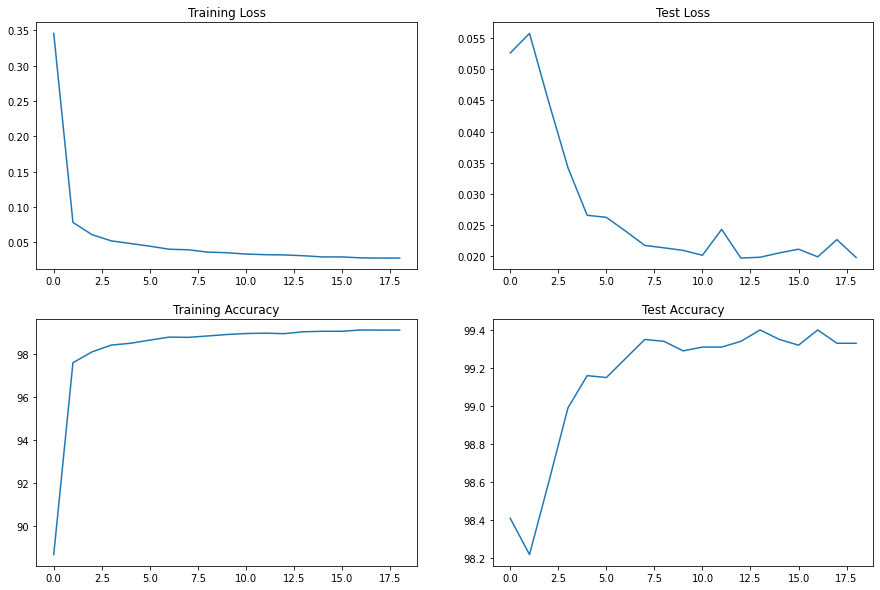

In [ ]:
print('Train Accuracy: ', max(train_acc_list))
print('Test Accuracy: ', max(test_acc_list))

utils.plot_loss_acc(train_loss_list, train_acc_list, test_loss_list, test_acc_list)

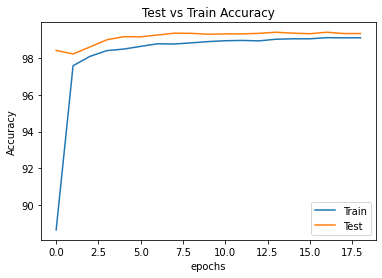

In [ ]:
utils.plot_combined(train_acc_list, test_acc_list)

#### Results

Train Accuracy: **99.105**  
Test Accuracy: **99.40**

### Training Model 2 - BN + GAP + FC + DropOut


In [ ]:
model = Net2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train(model, device, train_loader, optimizer)
    test_loss, test_acc = test(model, device, test_loader)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    
    print('\nTRAIN set: Average loss: {:.4f}, Train Accuracy: {:.2f}%'.format(train_loss,train_acc))
    print('TEST set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss,test_acc))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.3820, Train Accuracy: 87.29%
TEST set: Average loss: 0.0842, Test Accuracy: 97.43%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0959, Train Accuracy: 96.99%
TEST set: Average loss: 0.0433, Test Accuracy: 98.77%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0740, Train Accuracy: 97.70%
TEST set: Average loss: 0.0418, Test Accuracy: 98.73%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0690, Train Accuracy: 97.83%
TEST set: Average loss: 0.0446, Test Accuracy: 98.62%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0614, Train Accuracy: 98.06%
TEST set: Average loss: 0.0378, Test Accuracy: 98.83%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0572, Train Accuracy: 98.21%
TEST set: Average loss: 0.0452, Test Accuracy: 98.54%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 7


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0543, Train Accuracy: 98.33%
TEST set: Average loss: 0.0300, Test Accuracy: 99.06%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 8


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0508, Train Accuracy: 98.41%
TEST set: Average loss: 0.0314, Test Accuracy: 99.01%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 9


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0480, Train Accuracy: 98.52%
TEST set: Average loss: 0.0287, Test Accuracy: 98.99%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 10


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0484, Train Accuracy: 98.42%
TEST set: Average loss: 0.0274, Test Accuracy: 99.11%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 11


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0453, Train Accuracy: 98.58%
TEST set: Average loss: 0.0250, Test Accuracy: 99.20%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 12


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0445, Train Accuracy: 98.54%
TEST set: Average loss: 0.0288, Test Accuracy: 99.10%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 13


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0435, Train Accuracy: 98.62%
TEST set: Average loss: 0.0293, Test Accuracy: 98.93%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 14


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0424, Train Accuracy: 98.62%
TEST set: Average loss: 0.0253, Test Accuracy: 99.15%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 15


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0404, Train Accuracy: 98.73%
TEST set: Average loss: 0.0227, Test Accuracy: 99.35%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 16


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0398, Train Accuracy: 98.72%
TEST set: Average loss: 0.0251, Test Accuracy: 99.27%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 17


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0392, Train Accuracy: 98.72%
TEST set: Average loss: 0.0243, Test Accuracy: 99.26%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 18


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0394, Train Accuracy: 98.73%
TEST set: Average loss: 0.0242, Test Accuracy: 99.20%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 19


loss=0.005358813796192408 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 46.34it/s]



TRAIN set: Average loss: 0.0383, Train Accuracy: 98.76%
TEST set: Average loss: 0.0210, Test Accuracy: 99.27%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Train Accuracy:  98.76166666666667
Test Accuracy:  99.35


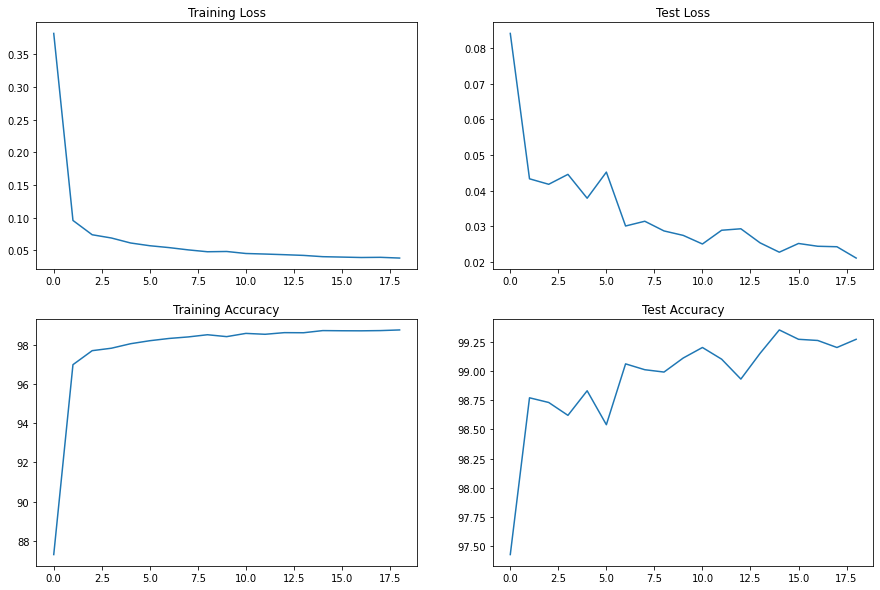

In [ ]:
print('Train Accuracy: ', max(train_acc_list))
print('Test Accuracy: ', max(test_acc_list))

utils.plot_loss_acc(train_loss_list, train_acc_list, test_loss_list, test_acc_list)

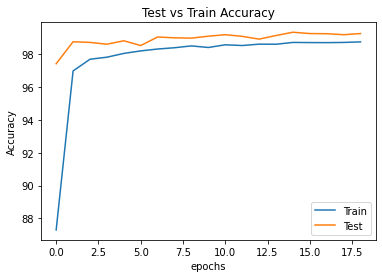

In [ ]:
utils.plot_combined(train_acc_list, test_acc_list)

#### Results

Train Accuracy: **98.76**  
Test Accuracy: **99.35**

# Let's Train using LR Scheduler

We can see that from epoch 12, it reached 98.75, but than started to oscillate and was moving up and down.

So we can use LR Scheduler which will change the Learning Rate, as we go deep and deep in number of epochs.


## StepLR

### Training Model 1 - BN + GAP + FC + StepLR

In [ ]:
from torch.optim.lr_scheduler import StepLR

model = Net1().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size= 8, gamma= 0.25)

train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train(model, device, train_loader, optimizer)
    test_loss, test_acc = test(model, device, test_loader)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    scheduler.step()
    
    print('\nTRAIN set: Average loss: {:.4f}, Train Accuracy: {:.2f}%'.format(train_loss,train_acc))
    print('TEST set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss,test_acc))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.3516, Train Accuracy: 88.70%
TEST set: Average loss: 0.0585, Test Accuracy: 98.19%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0804, Train Accuracy: 97.47%
TEST set: Average loss: 0.0489, Test Accuracy: 98.39%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0648, Train Accuracy: 98.00%
TEST set: Average loss: 0.0380, Test Accuracy: 98.78%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0545, Train Accuracy: 98.29%
TEST set: Average loss: 0.0304, Test Accuracy: 98.91%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0494, Train Accuracy: 98.45%
TEST set: Average loss: 0.0285, Test Accuracy: 99.12%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0458, Train Accuracy: 98.56%
TEST set: Average loss: 0.0275, Test Accuracy: 99.18%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 7


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0423, Train Accuracy: 98.64%
TEST set: Average loss: 0.0293, Test Accuracy: 99.06%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 8


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0399, Train Accuracy: 98.77%
TEST set: Average loss: 0.0270, Test Accuracy: 99.15%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 9


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0310, Train Accuracy: 99.02%
TEST set: Average loss: 0.0248, Test Accuracy: 99.23%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 10


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0288, Train Accuracy: 99.11%
TEST set: Average loss: 0.0233, Test Accuracy: 99.26%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 11


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0286, Train Accuracy: 99.08%
TEST set: Average loss: 0.0246, Test Accuracy: 99.24%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 12


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0270, Train Accuracy: 99.14%
TEST set: Average loss: 0.0220, Test Accuracy: 99.32%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 13


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0264, Train Accuracy: 99.19%
TEST set: Average loss: 0.0230, Test Accuracy: 99.35%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 14


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0273, Train Accuracy: 99.12%
TEST set: Average loss: 0.0223, Test Accuracy: 99.31%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 15


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0262, Train Accuracy: 99.22%
TEST set: Average loss: 0.0220, Test Accuracy: 99.34%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 16


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0257, Train Accuracy: 99.22%
TEST set: Average loss: 0.0229, Test Accuracy: 99.28%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 17


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0230, Train Accuracy: 99.25%
TEST set: Average loss: 0.0226, Test Accuracy: 99.30%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 18


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0239, Train Accuracy: 99.25%
TEST set: Average loss: 0.0218, Test Accuracy: 99.29%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 19


loss=0.018911607563495636 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.09it/s]



TRAIN set: Average loss: 0.0234, Train Accuracy: 99.27%
TEST set: Average loss: 0.0217, Test Accuracy: 99.27%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Train Accuracy:  99.26666666666667
Test Accuracy:  99.35


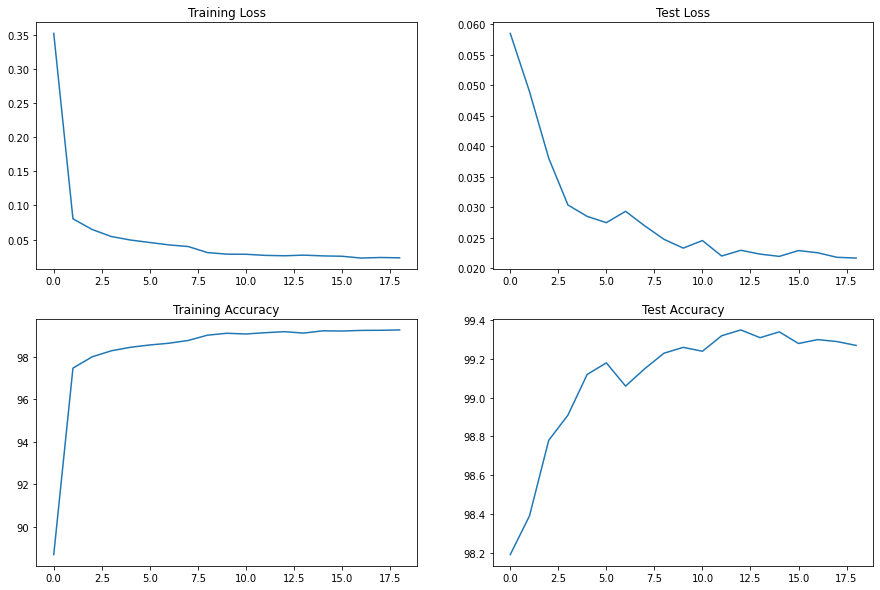

In [ ]:
print('Train Accuracy: ', max(train_acc_list))
print('Test Accuracy: ', max(test_acc_list))

utils.plot_loss_acc(train_loss_list, train_acc_list, test_loss_list, test_acc_list)

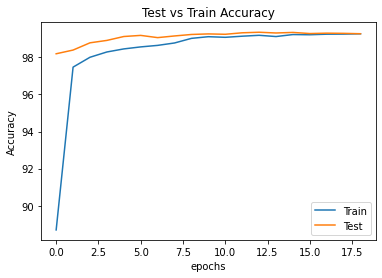

In [ ]:
utils.plot_combined(train_acc_list, test_acc_list)

#### Results

Train Accuracy: **99.26**  
Test Accuracy: **99.35**

### Training Model 2 - BN + GAP + FC + DropOut + StepLR

In [ ]:
from torch.optim.lr_scheduler import StepLR

model = Net2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size= 9, gamma= 0.3)

train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train(model, device, train_loader, optimizer)
    test_loss, test_acc = test(model, device, test_loader)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    scheduler.step()
    
    print('\nTRAIN set: Average loss: {:.4f}, Train Accuracy: {:.2f}%'.format(train_loss,train_acc))
    print('TEST set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss,test_acc))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.3555, Train Accuracy: 88.30%
TEST set: Average loss: 0.0607, Test Accuracy: 98.12%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0966, Train Accuracy: 96.98%
TEST set: Average loss: 0.0677, Test Accuracy: 97.79%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0795, Train Accuracy: 97.51%
TEST set: Average loss: 0.0452, Test Accuracy: 98.57%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0673, Train Accuracy: 97.86%
TEST set: Average loss: 0.0351, Test Accuracy: 98.88%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0622, Train Accuracy: 98.10%
TEST set: Average loss: 0.0372, Test Accuracy: 98.77%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0560, Train Accuracy: 98.26%
TEST set: Average loss: 0.0397, Test Accuracy: 98.67%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 7


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0548, Train Accuracy: 98.31%
TEST set: Average loss: 0.0304, Test Accuracy: 99.02%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 8


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0513, Train Accuracy: 98.41%
TEST set: Average loss: 0.0263, Test Accuracy: 99.16%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 9


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0489, Train Accuracy: 98.43%
TEST set: Average loss: 0.0300, Test Accuracy: 99.02%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 10


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0413, Train Accuracy: 98.68%
TEST set: Average loss: 0.0257, Test Accuracy: 99.12%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 11


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0394, Train Accuracy: 98.75%
TEST set: Average loss: 0.0257, Test Accuracy: 99.09%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 12


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0390, Train Accuracy: 98.73%
TEST set: Average loss: 0.0235, Test Accuracy: 99.23%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 13


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0369, Train Accuracy: 98.84%
TEST set: Average loss: 0.0241, Test Accuracy: 99.17%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 14


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0373, Train Accuracy: 98.81%
TEST set: Average loss: 0.0242, Test Accuracy: 99.21%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 15


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0364, Train Accuracy: 98.86%
TEST set: Average loss: 0.0248, Test Accuracy: 99.15%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 16


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0373, Train Accuracy: 98.82%
TEST set: Average loss: 0.0240, Test Accuracy: 99.20%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 17


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0355, Train Accuracy: 98.90%
TEST set: Average loss: 0.0252, Test Accuracy: 99.22%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 18


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0372, Train Accuracy: 98.87%
TEST set: Average loss: 0.0226, Test Accuracy: 99.23%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 19


loss=0.03356989845633507 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 49.11it/s]



TRAIN set: Average loss: 0.0352, Train Accuracy: 98.89%
TEST set: Average loss: 0.0226, Test Accuracy: 99.24%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Train Accuracy:  98.89833333333333
Test Accuracy:  99.24


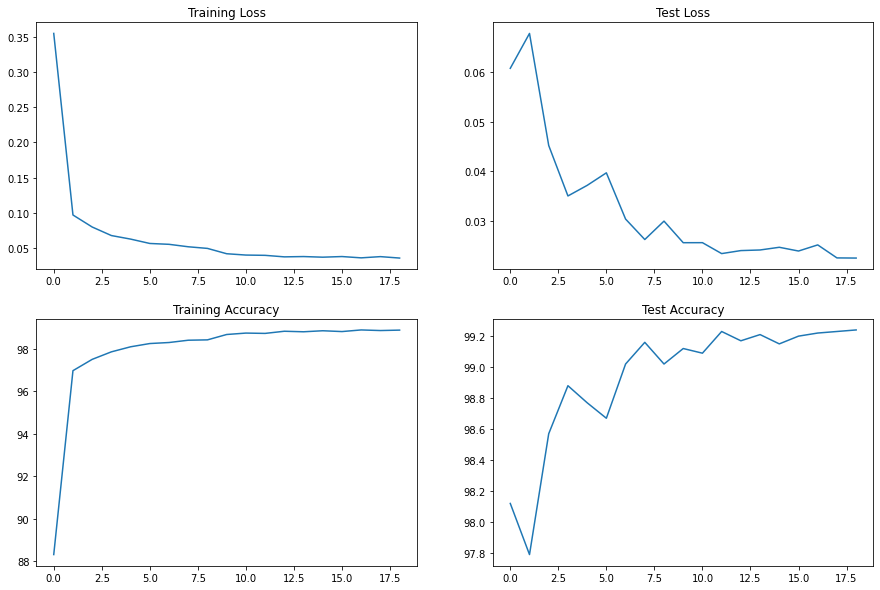

In [ ]:
print('Train Accuracy: ', max(train_acc_list))
print('Test Accuracy: ', max(test_acc_list))

utils.plot_loss_acc(train_loss_list, train_acc_list, test_loss_list, test_acc_list)

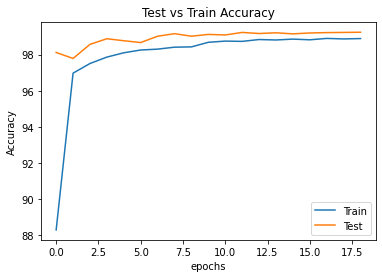

In [ ]:
utils.plot_combined(train_acc_list, test_acc_list)

#### Results

Train Accuracy: **98.89**  
Test Accuracy: **99.24**

## ReduceLROnPlateau

### Training Model 1 - BN + GAP + FC with ReduceLROnPlateau

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = Net1().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.2, patience=4, 
                            threshold=0.3, threshold_mode='abs', verbose=True)

train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train(model, device, train_loader, optimizer)
    test_loss, test_acc = test(model, device, test_loader)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    scheduler.step(test_acc)
    
    print('\nTRAIN set: Average loss: {:.4f}, Train Accuracy: {:.2f}%'.format(train_loss,train_acc))
    print('TEST set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss,test_acc))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.3736, Train Accuracy: 87.60%
TEST set: Average loss: 0.0653, Test Accuracy: 98.02%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0824, Train Accuracy: 97.45%
TEST set: Average loss: 0.0491, Test Accuracy: 98.32%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0653, Train Accuracy: 97.97%
TEST set: Average loss: 0.0405, Test Accuracy: 98.73%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0586, Train Accuracy: 98.18%
TEST set: Average loss: 0.0375, Test Accuracy: 98.73%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0525, Train Accuracy: 98.36%
TEST set: Average loss: 0.0356, Test Accuracy: 98.88%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0481, Train Accuracy: 98.51%
TEST set: Average loss: 0.0336, Test Accuracy: 98.88%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 7


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0440, Train Accuracy: 98.62%
TEST set: Average loss: 0.0268, Test Accuracy: 99.08%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 8


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0423, Train Accuracy: 98.66%
TEST set: Average loss: 0.0298, Test Accuracy: 99.04%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 9


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0400, Train Accuracy: 98.72%
TEST set: Average loss: 0.0318, Test Accuracy: 98.96%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 10


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0378, Train Accuracy: 98.79%
TEST set: Average loss: 0.0216, Test Accuracy: 99.32%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 11


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0375, Train Accuracy: 98.80%
TEST set: Average loss: 0.0262, Test Accuracy: 99.24%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 12


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch    12: reducing learning rate of group 0 to 2.0000e-03.

TRAIN set: Average loss: 0.0348, Train Accuracy: 98.90%
TEST set: Average loss: 0.0247, Test Accuracy: 99.12%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 13


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0270, Train Accuracy: 99.13%
TEST set: Average loss: 0.0214, Test Accuracy: 99.28%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 14


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0260, Train Accuracy: 99.17%
TEST set: Average loss: 0.0205, Test Accuracy: 99.25%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 15


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0243, Train Accuracy: 99.22%
TEST set: Average loss: 0.0198, Test Accuracy: 99.37%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 16


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0251, Train Accuracy: 99.22%
TEST set: Average loss: 0.0197, Test Accuracy: 99.31%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 17


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch    17: reducing learning rate of group 0 to 4.0000e-04.

TRAIN set: Average loss: 0.0243, Train Accuracy: 99.22%
TEST set: Average loss: 0.0202, Test Accuracy: 99.26%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 18


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0234, Train Accuracy: 99.25%
TEST set: Average loss: 0.0196, Test Accuracy: 99.32%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 19


loss=0.00663700932636857 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 48.70it/s]



TRAIN set: Average loss: 0.0229, Train Accuracy: 99.28%
TEST set: Average loss: 0.0196, Test Accuracy: 99.31%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Train Accuracy:  99.28
Test Accuracy:  99.37


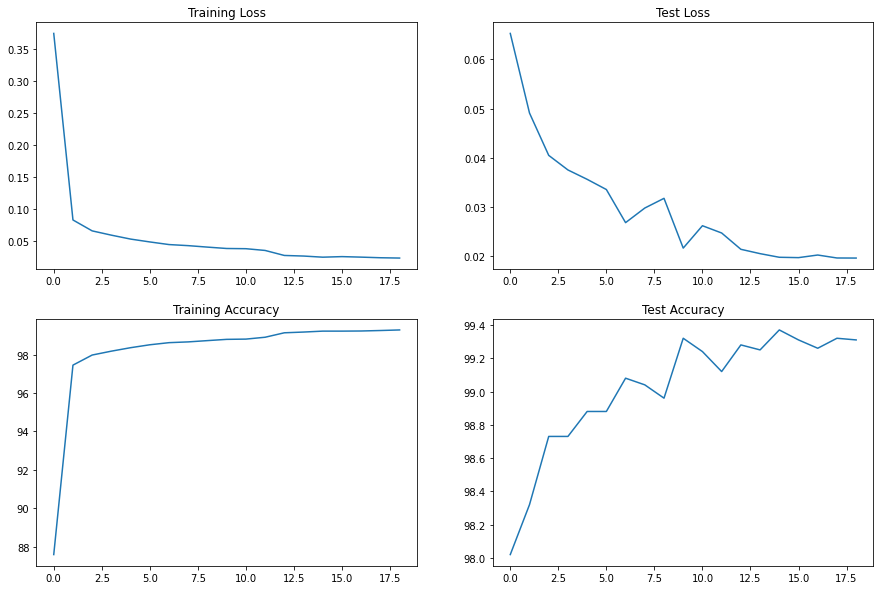

In [ ]:
print('Train Accuracy: ', max(train_acc_list))
print('Test Accuracy: ', max(test_acc_list))

utils.plot_loss_acc(train_loss_list, train_acc_list, test_loss_list, test_acc_list)

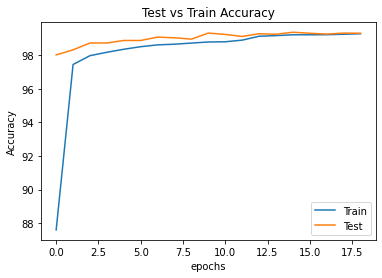

In [ ]:
utils.plot_combined(train_acc_list, test_acc_list)

#### Results

Train Accuracy: **99.28**  
Test Accuracy: **99.37**

### Training Model 2 - BN + GAP + FC + DropOut with ReduceLROnPlateau

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = Net2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.66, patience=4, 
                            threshold=0.3, threshold_mode='abs', verbose=True)

train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train(model, device, train_loader, optimizer)
    test_loss, test_acc = test(model, device, test_loader)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    scheduler.step(test_acc)
    
    print('\nTRAIN set: Average loss: {:.4f}, Train Accuracy: {:.2f}%'.format(train_loss,train_acc))
    print('TEST set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss,test_acc))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.3714, Train Accuracy: 87.89%
TEST set: Average loss: 0.0673, Test Accuracy: 97.92%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0926, Train Accuracy: 97.13%
TEST set: Average loss: 0.0550, Test Accuracy: 98.25%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0739, Train Accuracy: 97.63%
TEST set: Average loss: 0.0366, Test Accuracy: 98.75%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0675, Train Accuracy: 97.81%
TEST set: Average loss: 0.0614, Test Accuracy: 97.98%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0603, Train Accuracy: 98.08%
TEST set: Average loss: 0.0381, Test Accuracy: 98.70%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0537, Train Accuracy: 98.33%
TEST set: Average loss: 0.0320, Test Accuracy: 99.01%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 7


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0524, Train Accuracy: 98.35%
TEST set: Average loss: 0.0267, Test Accuracy: 99.15%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 8


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0477, Train Accuracy: 98.47%
TEST set: Average loss: 0.0286, Test Accuracy: 98.96%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 9


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0469, Train Accuracy: 98.54%
TEST set: Average loss: 0.0270, Test Accuracy: 99.11%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 10


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0457, Train Accuracy: 98.59%
TEST set: Average loss: 0.0265, Test Accuracy: 99.06%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 11


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0438, Train Accuracy: 98.64%
TEST set: Average loss: 0.0266, Test Accuracy: 99.15%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 12


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch    12: reducing learning rate of group 0 to 6.6000e-03.

TRAIN set: Average loss: 0.0421, Train Accuracy: 98.64%
TEST set: Average loss: 0.0263, Test Accuracy: 99.09%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 13


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0383, Train Accuracy: 98.76%
TEST set: Average loss: 0.0217, Test Accuracy: 99.28%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 14


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0360, Train Accuracy: 98.83%
TEST set: Average loss: 0.0259, Test Accuracy: 99.20%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 15


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0358, Train Accuracy: 98.85%
TEST set: Average loss: 0.0220, Test Accuracy: 99.27%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 16


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0357, Train Accuracy: 98.86%
TEST set: Average loss: 0.0225, Test Accuracy: 99.27%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 17


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch    17: reducing learning rate of group 0 to 4.3560e-03.

TRAIN set: Average loss: 0.0365, Train Accuracy: 98.82%
TEST set: Average loss: 0.0219, Test Accuracy: 99.21%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 18


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0338, Train Accuracy: 98.92%
TEST set: Average loss: 0.0204, Test Accuracy: 99.34%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 19


loss=0.2068796455860138 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 48.57it/s]



TRAIN set: Average loss: 0.0312, Train Accuracy: 98.97%
TEST set: Average loss: 0.0189, Test Accuracy: 99.42%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Train Accuracy:  98.975
Test Accuracy:  99.42


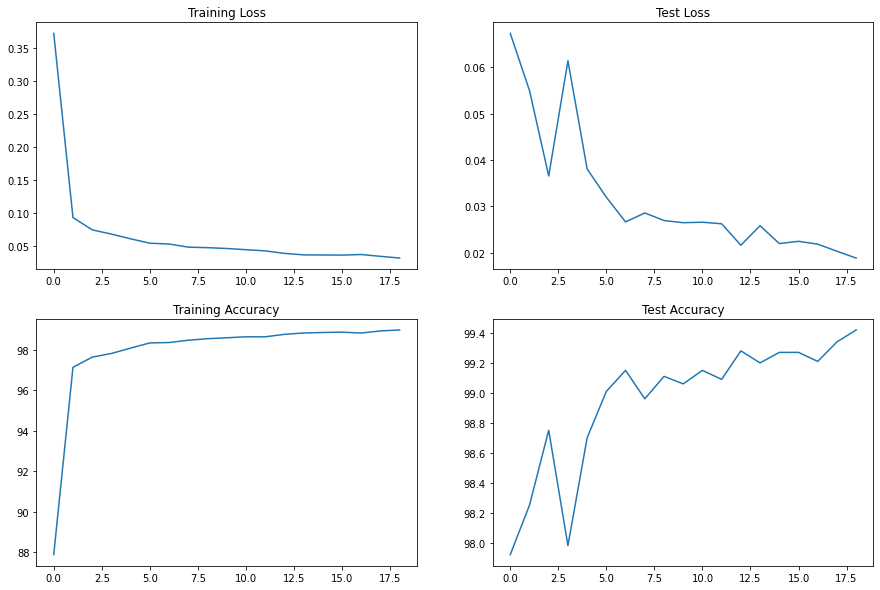

In [ ]:
print('Train Accuracy: ', max(train_acc_list))
print('Test Accuracy: ', max(test_acc_list))

utils.plot_loss_acc(train_loss_list, train_acc_list, test_loss_list, test_acc_list)

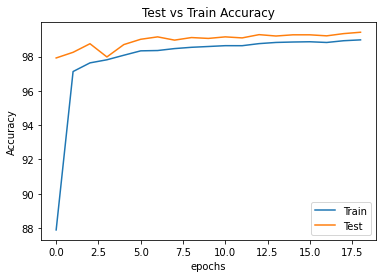

In [ ]:
utils.plot_combined(train_acc_list, test_acc_list)

#### Results

Train Accuracy: **98.975**  
Test Accuracy: **99.42**

# New Architecture with only One Max Pool

## Model 3 - One Max Pool + BN + GAP + FC

In [ ]:
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1) # 28x28x3 -> 28x28x8
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 8, 3, padding=1) # 28x28x8 -> 28x28x8
        self.bn2 = nn.BatchNorm2d(8)
        self.pool1 = nn.MaxPool2d(2, 2) # 28x28x8 -> 14x14x8
        
        self.conv3 = nn.Conv2d(8, 8, 3) # 14x14x12 -> 12x12x16
        self.bn3 = nn.BatchNorm2d(8)
        self.conv4 = nn.Conv2d(8, 8, 3) # 12x12x8 -> 10x10x12
        self.bn4 = nn.BatchNorm2d(8)
        self.conv5 = nn.Conv2d(8, 16, 3) # 10x10x12 -> 8x8x12
        self.bn5 = nn.BatchNorm2d(16)
        self.conv6 = nn.Conv2d(16, 16, 3) # 8x8x12 -> 6x6x16
        
        self.gap = nn.AvgPool2d(6) # 3x3x32 -> 1x1x32
        self.fc1 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.pool1(x)

        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)))
        x = self.gap(self.conv6(x))
        x = x.view(-1,16)
        x = self.fc2(F.relu(self.fc1(x)))        
        
        
        return F.log_softmax(x, dim=1)

In [ ]:
model = Net3().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
            Conv2d-3            [-1, 8, 28, 28]             584
       BatchNorm2d-4            [-1, 8, 28, 28]              16
         MaxPool2d-5            [-1, 8, 14, 14]               0
            Conv2d-6            [-1, 8, 12, 12]             584
       BatchNorm2d-7            [-1, 8, 12, 12]              16
            Conv2d-8            [-1, 8, 10, 10]             584
       BatchNorm2d-9            [-1, 8, 10, 10]              16
           Conv2d-10             [-1, 16, 8, 8]           1,168
      BatchNorm2d-11             [-1, 16, 8, 8]              32
           Conv2d-12             [-1, 16, 6, 6]           2,320
        AvgPool2d-13             [-1, 16, 1, 1]               0
           Linear-14                   

## Model 4 - One Max Pool + BN + GAP + FC + DropOut

In [ ]:
class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1) # 28x28x3 -> 28x28x8
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 8, 3, padding=1) # 28x28x8 -> 28x28x8
        self.bn2 = nn.BatchNorm2d(8)
        self.pool1 = nn.MaxPool2d(2, 2) # 28x28x8 -> 14x14x8
        
        self.conv3 = nn.Conv2d(8, 8, 3) # 14x14x12 -> 12x12x16
        self.bn3 = nn.BatchNorm2d(8)
        self.conv4 = nn.Conv2d(8, 8, 3) # 12x12x8 -> 10x10x12
        self.bn4 = nn.BatchNorm2d(8)
        self.conv5 = nn.Conv2d(8, 16, 3) # 10x10x12 -> 8x8x12
        self.bn5 = nn.BatchNorm2d(16)
        self.conv6 = nn.Conv2d(16, 16, 3) # 8x8x12 -> 6x6x16
        
        self.gap = nn.AvgPool2d(6) # 3x3x32 -> 1x1x32
        self.fc1 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 10)

        self.drop = nn.Dropout(p=0.05) #5% Neurons being Dropped

    def forward(self, x):
        x = self.drop(self.bn1(F.relu(self.conv1(x))))
        x = self.drop(self.bn2(F.relu(self.conv2(x))))
        x = self.pool1(x)

        x = self.drop(self.bn3(F.relu(self.conv3(x))))
        x = self.drop(self.bn4(F.relu(self.conv4(x))))
        x = self.drop(self.bn5(F.relu(self.conv5(x))))
        x = self.gap(self.conv6(x))
        x = x.view(-1,16)
        x = self.fc2(F.relu(self.fc1(x)))
        
        
        return F.log_softmax(x, dim=1)

In [ ]:
model = Net4().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
           Dropout-3            [-1, 8, 28, 28]               0
            Conv2d-4            [-1, 8, 28, 28]             584
       BatchNorm2d-5            [-1, 8, 28, 28]              16
           Dropout-6            [-1, 8, 28, 28]               0
         MaxPool2d-7            [-1, 8, 14, 14]               0
            Conv2d-8            [-1, 8, 12, 12]             584
       BatchNorm2d-9            [-1, 8, 12, 12]              16
          Dropout-10            [-1, 8, 12, 12]               0
           Conv2d-11            [-1, 8, 10, 10]             584
      BatchNorm2d-12            [-1, 8, 10, 10]              16
          Dropout-13            [-1, 8, 10, 10]               0
           Conv2d-14             [-1, 1

## Model 3 - with StepLR Scheduler

In [ ]:
from torch.optim.lr_scheduler import StepLR

model = Net3().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size= 9, gamma= 0.3)

train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train(model, device, train_loader, optimizer)
    test_loss, test_acc = test(model, device, test_loader)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    scheduler.step()
    
    print('\nTRAIN set: Average loss: {:.4f}, Train Accuracy: {:.2f}%'.format(train_loss,train_acc))
    print('TEST set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss,test_acc))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.4674, Train Accuracy: 83.99%
TEST set: Average loss: 0.0847, Test Accuracy: 97.24%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0924, Train Accuracy: 97.09%
TEST set: Average loss: 0.0674, Test Accuracy: 97.64%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0743, Train Accuracy: 97.71%
TEST set: Average loss: 0.0383, Test Accuracy: 98.86%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0639, Train Accuracy: 97.95%
TEST set: Average loss: 0.0420, Test Accuracy: 98.50%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0571, Train Accuracy: 98.19%
TEST set: Average loss: 0.0305, Test Accuracy: 99.02%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0504, Train Accuracy: 98.38%
TEST set: Average loss: 0.0312, Test Accuracy: 99.02%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 7


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0469, Train Accuracy: 98.51%
TEST set: Average loss: 0.0312, Test Accuracy: 99.02%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 8


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0453, Train Accuracy: 98.54%
TEST set: Average loss: 0.0269, Test Accuracy: 99.07%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 9


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0424, Train Accuracy: 98.70%
TEST set: Average loss: 0.0243, Test Accuracy: 99.23%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 10


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0340, Train Accuracy: 98.91%
TEST set: Average loss: 0.0233, Test Accuracy: 99.32%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 11


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0317, Train Accuracy: 99.03%
TEST set: Average loss: 0.0233, Test Accuracy: 99.26%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 12


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0314, Train Accuracy: 98.98%
TEST set: Average loss: 0.0221, Test Accuracy: 99.35%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 13


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0302, Train Accuracy: 99.07%
TEST set: Average loss: 0.0205, Test Accuracy: 99.37%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 14


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0291, Train Accuracy: 99.04%
TEST set: Average loss: 0.0209, Test Accuracy: 99.35%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 15


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0295, Train Accuracy: 99.06%
TEST set: Average loss: 0.0211, Test Accuracy: 99.40%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 16


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0291, Train Accuracy: 99.05%
TEST set: Average loss: 0.0201, Test Accuracy: 99.37%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 17


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0287, Train Accuracy: 99.09%
TEST set: Average loss: 0.0211, Test Accuracy: 99.35%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 18


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0289, Train Accuracy: 99.09%
TEST set: Average loss: 0.0196, Test Accuracy: 99.37%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 19


loss=0.006689200643450022 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 48.51it/s]



TRAIN set: Average loss: 0.0264, Train Accuracy: 99.13%
TEST set: Average loss: 0.0193, Test Accuracy: 99.37%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Train Accuracy:  99.12833333333333
Test Accuracy:  99.4


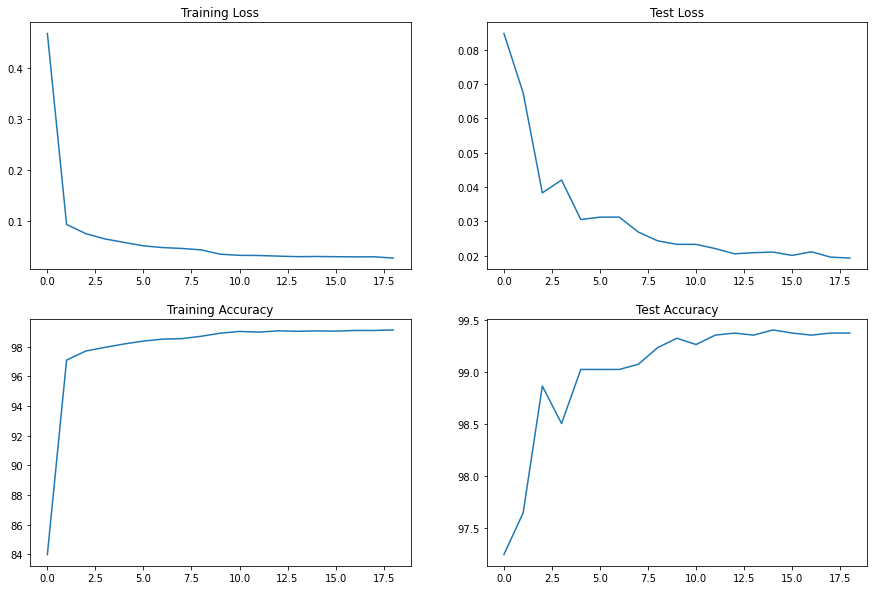

In [ ]:
print('Train Accuracy: ', max(train_acc_list))
print('Test Accuracy: ', max(test_acc_list))

utils.plot_loss_acc(train_loss_list, train_acc_list, test_loss_list, test_acc_list)

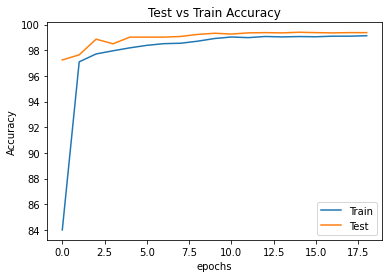

In [ ]:
utils.plot_combined(train_acc_list, test_acc_list)

### Results

Train Accuracy: **99.12**  
Test Accuracy: **99.4**

## Model 3 - with ReduceLRonPlateau Scheduler

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = Net3().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.2, patience=4, 
                            threshold=0.3, threshold_mode='abs', verbose=True)

train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train(model, device, train_loader, optimizer)
    test_loss, test_acc = test(model, device, test_loader)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    scheduler.step(test_acc)
    
    print('\nTRAIN set: Average loss: {:.4f}, Train Accuracy: {:.2f}%'.format(train_loss,train_acc))
    print('TEST set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss,test_acc))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.4473, Train Accuracy: 85.09%
TEST set: Average loss: 0.0791, Test Accuracy: 97.60%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0895, Train Accuracy: 97.25%
TEST set: Average loss: 0.0642, Test Accuracy: 98.01%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0713, Train Accuracy: 97.76%
TEST set: Average loss: 0.0407, Test Accuracy: 98.75%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0612, Train Accuracy: 98.15%
TEST set: Average loss: 0.0382, Test Accuracy: 98.83%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0518, Train Accuracy: 98.39%
TEST set: Average loss: 0.0350, Test Accuracy: 98.86%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0472, Train Accuracy: 98.49%
TEST set: Average loss: 0.0297, Test Accuracy: 99.10%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 7


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0461, Train Accuracy: 98.55%
TEST set: Average loss: 0.0248, Test Accuracy: 99.20%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 8


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0431, Train Accuracy: 98.65%
TEST set: Average loss: 0.0289, Test Accuracy: 99.18%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 9


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0405, Train Accuracy: 98.75%
TEST set: Average loss: 0.0313, Test Accuracy: 99.02%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 10


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0391, Train Accuracy: 98.77%
TEST set: Average loss: 0.0259, Test Accuracy: 99.26%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 11


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch    11: reducing learning rate of group 0 to 2.0000e-03.

TRAIN set: Average loss: 0.0365, Train Accuracy: 98.84%
TEST set: Average loss: 0.0231, Test Accuracy: 99.23%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 12


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0295, Train Accuracy: 99.09%
TEST set: Average loss: 0.0195, Test Accuracy: 99.46%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 13


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0279, Train Accuracy: 99.09%
TEST set: Average loss: 0.0202, Test Accuracy: 99.42%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 14


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0267, Train Accuracy: 99.11%
TEST set: Average loss: 0.0195, Test Accuracy: 99.47%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 15


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0260, Train Accuracy: 99.17%
TEST set: Average loss: 0.0200, Test Accuracy: 99.37%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 16


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0272, Train Accuracy: 99.16%
TEST set: Average loss: 0.0194, Test Accuracy: 99.42%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 17


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch    17: reducing learning rate of group 0 to 4.0000e-04.

TRAIN set: Average loss: 0.0268, Train Accuracy: 99.13%
TEST set: Average loss: 0.0192, Test Accuracy: 99.45%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 18


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0245, Train Accuracy: 99.23%
TEST set: Average loss: 0.0189, Test Accuracy: 99.47%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 19


loss=0.004883105866611004 batch_id=937: 100%|██████████| 938/938 [00:18<00:00, 50.50it/s]



TRAIN set: Average loss: 0.0250, Train Accuracy: 99.18%
TEST set: Average loss: 0.0190, Test Accuracy: 99.45%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Train Accuracy:  99.23333333333333
Test Accuracy:  99.47


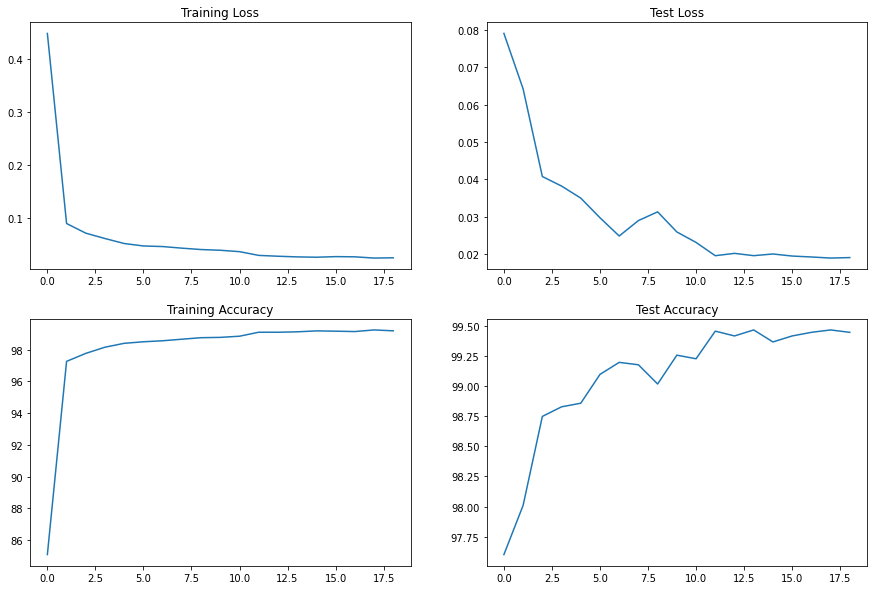

In [ ]:
print('Train Accuracy: ', max(train_acc_list))
print('Test Accuracy: ', max(test_acc_list))

utils.plot_loss_acc(train_loss_list, train_acc_list, test_loss_list, test_acc_list)

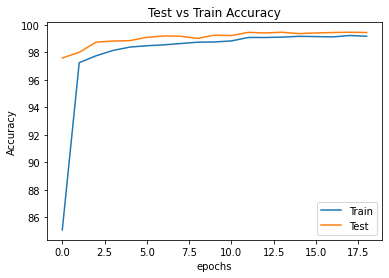

In [ ]:
utils.plot_combined(train_acc_list, test_acc_list)

### Results

Train Accuracy: **99.23**  
Test Accuracy: **99.47**

## Model 4 - with StepLR Scheduler

In [ ]:
model = Net4().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size= 9, gamma= 0.3)

train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train(model, device, train_loader, optimizer)
    test_loss, test_acc = test(model, device, test_loader)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    scheduler.step()
    
    print('\nTRAIN set: Average loss: {:.4f}, Train Accuracy: {:.2f}%'.format(train_loss,train_acc))
    print('TEST set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss,test_acc))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.5004, Train Accuracy: 82.93%
TEST set: Average loss: 0.0773, Test Accuracy: 97.65%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.1030, Train Accuracy: 96.80%
TEST set: Average loss: 0.0651, Test Accuracy: 97.85%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0814, Train Accuracy: 97.47%
TEST set: Average loss: 0.0466, Test Accuracy: 98.56%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0706, Train Accuracy: 97.79%
TEST set: Average loss: 0.0347, Test Accuracy: 98.94%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0617, Train Accuracy: 98.07%
TEST set: Average loss: 0.0376, Test Accuracy: 98.84%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0569, Train Accuracy: 98.22%
TEST set: Average loss: 0.0327, Test Accuracy: 98.92%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 7


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0562, Train Accuracy: 98.29%
TEST set: Average loss: 0.0287, Test Accuracy: 99.07%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 8


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0501, Train Accuracy: 98.39%
TEST set: Average loss: 0.0347, Test Accuracy: 98.92%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 9


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0489, Train Accuracy: 98.49%
TEST set: Average loss: 0.0273, Test Accuracy: 99.12%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 10


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0400, Train Accuracy: 98.74%
TEST set: Average loss: 0.0228, Test Accuracy: 99.29%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 11


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0385, Train Accuracy: 98.78%
TEST set: Average loss: 0.0240, Test Accuracy: 99.23%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 12


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0382, Train Accuracy: 98.79%
TEST set: Average loss: 0.0240, Test Accuracy: 99.26%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 13


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0379, Train Accuracy: 98.83%
TEST set: Average loss: 0.0236, Test Accuracy: 99.28%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 14


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0369, Train Accuracy: 98.81%
TEST set: Average loss: 0.0238, Test Accuracy: 99.23%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 15


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0387, Train Accuracy: 98.79%
TEST set: Average loss: 0.0217, Test Accuracy: 99.31%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 16


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0348, Train Accuracy: 98.86%
TEST set: Average loss: 0.0222, Test Accuracy: 99.33%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 17


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0378, Train Accuracy: 98.78%
TEST set: Average loss: 0.0225, Test Accuracy: 99.32%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 18


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0366, Train Accuracy: 98.84%
TEST set: Average loss: 0.0204, Test Accuracy: 99.40%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 19


loss=0.0005056448862887919 batch_id=937: 100%|██████████| 938/938 [00:18<00:00, 49.85it/s]



TRAIN set: Average loss: 0.0333, Train Accuracy: 98.91%
TEST set: Average loss: 0.0209, Test Accuracy: 99.37%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Train Accuracy:  98.90666666666667
Test Accuracy:  99.4


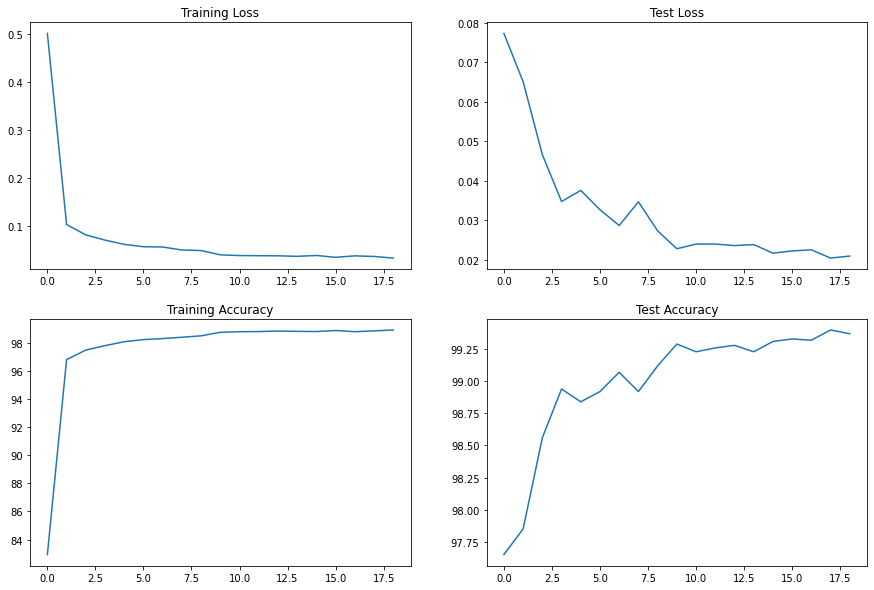

In [ ]:
print('Train Accuracy: ', max(train_acc_list))
print('Test Accuracy: ', max(test_acc_list))

utils.plot_loss_acc(train_loss_list, train_acc_list, test_loss_list, test_acc_list)

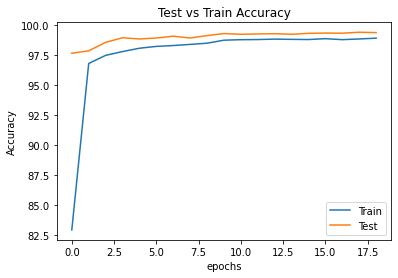

In [ ]:
utils.plot_combined(train_acc_list, test_acc_list)

### Results

Train Accuracy: **98.9**  
Test Accuracy: **99.4**

## Model 4 - with ReduceLRonPlateau Scheduler

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = Net4().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.2, patience=4, 
                            threshold=0.3, threshold_mode='abs', verbose=True)

train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train(model, device, train_loader, optimizer)
    test_loss, test_acc = test(model, device, test_loader)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    scheduler.step(test_acc)
    
    print('\nTRAIN set: Average loss: {:.4f}, Train Accuracy: {:.2f}%'.format(train_loss,train_acc))
    print('TEST set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss,test_acc))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.5102, Train Accuracy: 82.94%
TEST set: Average loss: 0.0825, Test Accuracy: 97.26%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.1114, Train Accuracy: 96.64%
TEST set: Average loss: 0.0679, Test Accuracy: 97.88%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0864, Train Accuracy: 97.30%
TEST set: Average loss: 0.0436, Test Accuracy: 98.55%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0759, Train Accuracy: 97.67%
TEST set: Average loss: 0.0398, Test Accuracy: 98.70%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0685, Train Accuracy: 97.92%
TEST set: Average loss: 0.0340, Test Accuracy: 98.87%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0616, Train Accuracy: 98.06%
TEST set: Average loss: 0.0334, Test Accuracy: 98.91%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 7


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0561, Train Accuracy: 98.28%
TEST set: Average loss: 0.0310, Test Accuracy: 99.04%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 8


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0548, Train Accuracy: 98.28%
TEST set: Average loss: 0.0309, Test Accuracy: 98.96%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 9


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0515, Train Accuracy: 98.35%
TEST set: Average loss: 0.0276, Test Accuracy: 99.10%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 10


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0492, Train Accuracy: 98.51%
TEST set: Average loss: 0.0264, Test Accuracy: 99.22%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 11


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0468, Train Accuracy: 98.54%
TEST set: Average loss: 0.0257, Test Accuracy: 99.18%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 12


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0471, Train Accuracy: 98.49%
TEST set: Average loss: 0.0252, Test Accuracy: 99.20%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 13


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0447, Train Accuracy: 98.57%
TEST set: Average loss: 0.0241, Test Accuracy: 99.23%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 14


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0438, Train Accuracy: 98.65%
TEST set: Average loss: 0.0222, Test Accuracy: 99.26%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 15


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch    15: reducing learning rate of group 0 to 2.0000e-03.

TRAIN set: Average loss: 0.0420, Train Accuracy: 98.68%
TEST set: Average loss: 0.0247, Test Accuracy: 99.17%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 16


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0362, Train Accuracy: 98.86%
TEST set: Average loss: 0.0198, Test Accuracy: 99.35%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 17


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0346, Train Accuracy: 98.91%
TEST set: Average loss: 0.0202, Test Accuracy: 99.36%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 18


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0347, Train Accuracy: 98.87%
TEST set: Average loss: 0.0209, Test Accuracy: 99.29%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 19


loss=0.005472279153764248 batch_id=937: 100%|██████████| 938/938 [00:18<00:00, 50.03it/s]



TRAIN set: Average loss: 0.0331, Train Accuracy: 98.96%
TEST set: Average loss: 0.0199, Test Accuracy: 99.34%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Train Accuracy:  98.96333333333334
Test Accuracy:  99.36


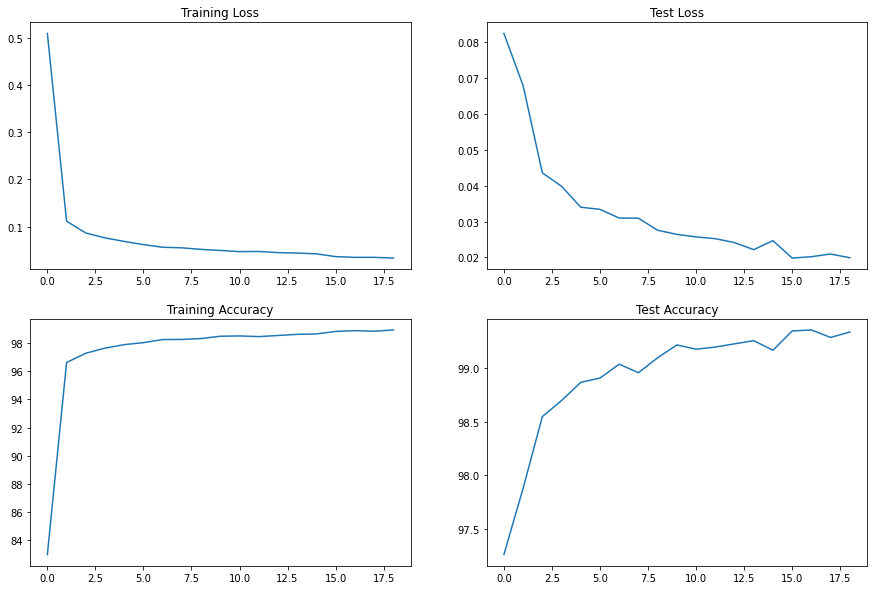

In [ ]:
print('Train Accuracy: ', max(train_acc_list))
print('Test Accuracy: ', max(test_acc_list))

utils.plot_loss_acc(train_loss_list, train_acc_list, test_loss_list, test_acc_list)

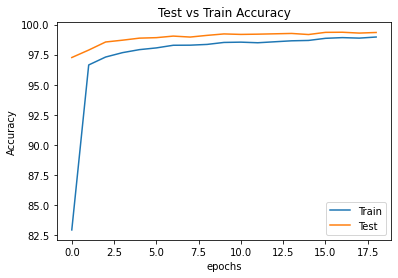

In [ ]:
utils.plot_combined(train_acc_list, test_acc_list)

### Results

Train Accuracy: **98.96**  
Test Accuracy: **99.36**

# Final Results

Model Name| No. Parameters| Scheduler| Data Aug|Train Accuracy| Test Accuracy 
:---:|:------------------:|:---:|:---:|:---:|:---:
Batch Norm + GAP + FC|6,290|N/A|Normalize|99.53|99.14    
Batch Norm + GAP + FC + DropOut|6,290|N/A|Normalize|99.195|99.28
------|------|------|------|------|------
Batch Norm + GAP + FC|6,290|N/A|Normalize + RandomRotate |99.105|**99.4**
Batch Norm + GAP + FC + DropOut|6,290|N/A|Normalize + RandomRotate|98.76|99.36    
------|------|------|------|------|------
Batch Norm + GAP + FC|6,290|StepLR|Normalize + RandomRotate|99.26|99.35
Batch Norm + GAP + FC + DropOut|6,290|StepLR|Normalize + RandomRotate|98.89|99.24
------|------|------|------|------|------
Batch Norm + GAP + FC|6,290|ReduceLROnPlateau|Normalize + RandomRotate|99.28|99.37
Batch Norm + GAP + FC + DropOut|6,290|ReduceLROnPlateau|Normalize + RandomRotate|99.975|**99.42**
------|------|------|------|------|------
One MP + Batch Norm + GAP + FC|6,290|StepLR|Normalize + RandomRotate|99.12|**99.4**
One MP + Batch Norm + GAP + FC + DropOut|6,290|StepLR|Normalize + RandomRotate|98.9|**99.4**
------|------|------|------|------|------
One MP + Batch Norm + GAP + FC|6,290|ReduceLROnPlateau|Normalize + RandomRotate|99.23|**99.47**
One MP + Batch Norm + GAP + FC + DropOut|6,290|ReduceLROnPlateau|Normalize + RandomRotate|98.96|99.36